In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import nltk.sentiment
import re

import warnings
warnings.filterwarnings('ignore')

from prepare import prep_readme_data

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)
plt.style.use('seaborn-darkgrid')

In [3]:
movie_title = pd.read_csv("IMDb movies.csv")

In [4]:
# What is are biggest markets in terms of movie production? 

movie_title.groupby("country").title.count().sort_values(ascending=False).nlargest(5)

country
USA       27490
India      5540
UK         3869
France     2975
Japan      2850
Name: title, dtype: int64

In [5]:
# What year did most movies get published?

movie_title.groupby("date_published").title.count().nlargest(10)

date_published
2010    111
1999    105
2008    101
1997     92
1985     90
1996     89
2009     89
1989     85
2011     85
1987     84
Name: title, dtype: int64

In [6]:
# What data range do we have? 

movie_title.date_published.min(), movie_title.date_published.max()

('1906-12-26', '2020-05-22')

In [7]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

For the purposes of this project, we will only look to use movies from the US. If the opportunity to scale up the project is possible, then we will add additional countries.

In [8]:
df = movie_title[(movie_title.country == "USA")]

In [9]:
# we see that we have a couple of missing values.
df.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      0
language                   307
director                    28
writer                     191
production_company        1139
actors                      22
description                 76
avg_vote                     0
votes                        0
budget                   17213
usa_gross_income         19940
worlwide_gross_income    19710
metascore                21145
reviews_from_users         279
reviews_from_critics      1728
dtype: int64

**Steps for Removing Null Values**:

1. The movie description will be a large part indicator or similarity, and as such, I want movies that have a description. I will drop any null values in this column
1. I will explore that language column, as I suspect at this moment that these shoud be all inglish
1. Similarly to the description, the director would play a big influence and as such I am thinking of dropping all null values from this column
1. While the meta score value would be really useful - there are too many missing values, and as such I will drop this column. Same for the `reviews_from_critics`
1. Might be able to impude a value for the missing `reviews_from_users`
1. I might be able to find the missing writers from the other IMBD file


In [10]:
# Given that hte majority of the movies are exclusively English, and we know that we are only looking at movies
# made in the US, I can speculate that it is very likely these movies were at least partially made in english
# As such, I will impode the missing values

df.language.value_counts()

English                                                              23976
English, Spanish                                                       695
English, French                                                        440
English, German                                                        198
English, Italian                                                       195
                                                                     ...  
English, French, Arabic, Romanian                                        1
Swedish                                                                  1
English, Spanish, Latin, French                                          1
English, American Sign Language, Dutch, Italian, Russian, Swahili        1
English, Hawaiian, French                                                1
Name: language, Length: 629, dtype: int64

In [11]:
df.language = df.language.fillna("English")

In [12]:
# remove nulls from director and description

df = df[df.description.notnull()]

In [13]:
df = df[df.director.notnull()]

In [14]:
df = df[df.writer.notnull()]

In [15]:
# What is the avg budget for all movies so that we can use it to impude values?

df.budget = df.budget.fillna("$ 0")

In [16]:
df = df[~df.budget.str.contains("ESP")]

df = df[~df.budget.str.contains("GBP")]

df = df[~df.budget.str.contains("CAD")]

df = df[~df.budget.str.contains("PYG")]

df = df[~df.budget.str.contains("AUD")]

df = df[~df.budget.str.contains("EUR")]

df = df[~df.budget.str.contains("RUR")]

In [17]:
avg_budget = df.budget.str.replace("$", '').astype(int).mean()

In [18]:
df.budget = df.budget.str.replace("$", '').astype(int)

In [19]:
df.budget = df.budget.replace(0, avg_budget)

In [20]:
# We will do something similar for US gross income

median_income = df[(df.usa_gross_income.notnull()) & (df.usa_gross_income.str.contains("$", regex=False))].usa_gross_income.str.replace("$", '').astype(int).median()

In [21]:
df.usa_gross_income = df.usa_gross_income.fillna("$ 0")

In [22]:
df.usa_gross_income = (
    df[df.usa_gross_income.str.contains("$", regex=False)]
    .usa_gross_income.str.replace("$", '')
    .astype(int)
    .replace(0, median_income)
)

In [23]:
# Remove columns with too many null values

df = df.drop(columns=["worlwide_gross_income", "metascore", "reviews_from_users", "reviews_from_critics"])

In [24]:
# Drop any remaining null values

df = df.dropna()

In [25]:
# Now we have no null values, and still have over 26000 movie titles

df.isnull().sum(), df.shape

(imdb_title_id         0
 title                 0
 original_title        0
 year                  0
 date_published        0
 genre                 0
 duration              0
 country               0
 language              0
 director              0
 writer                0
 production_company    0
 actors                0
 description           0
 avg_vote              0
 votes                 0
 budget                0
 usa_gross_income      0
 dtype: int64, (26102, 18))

## NLP Exploration

In [28]:
df_prep = prep_readme_data(df, "description")

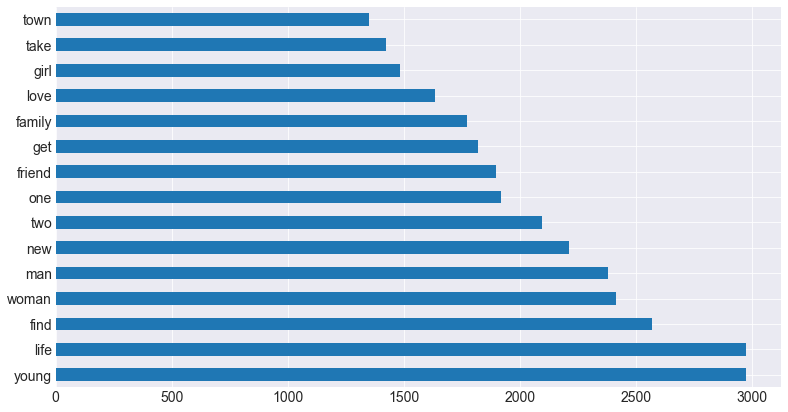

In [33]:
# What are the most common words in movie descriptions?

all_words = clean(' '.join(df.description))

pd.Series(all_words).value_counts().head(15).plot.barh()


### Common words by genre?

In [37]:
# What are the top most common genres?

df.genre.value_counts().head(5)

Drama             2294
Comedy            1810
Comedy, Drama      953
Horror             947
Drama, Romance     886
Name: genre, dtype: int64

In [41]:
drama = clean(' '.join(df[df.genre == "Drama"].description))
comedy = clean(' '.join(df[df.genre == "Comedy"].description))
comedy_drama = clean(' '.join(df[df.genre == "Comedy, Drama"].description))
horror = clean(' '.join(df[df.genre == "Horror"].description))
drame_romance = clean(' '.join(df[df.genre == "Drama, Romance"].description))

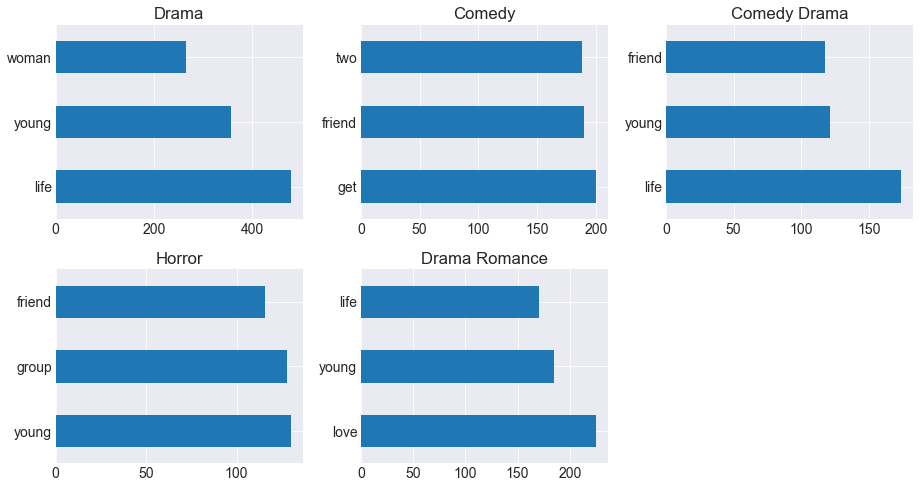

In [63]:
plt.subplot(2,3,1)
pd.Series(drama).value_counts().head(3).plot.barh()
plt.title("Drama")
plt.subplot(2,3,2)
pd.Series(comedy).value_counts().head(3).plot.barh()
plt.title("Comedy")
plt.subplot(2,3,3)
pd.Series(comedy_drama).value_counts().head(3).plot.barh()
plt.title("Comedy Drama")
plt.subplot(2,3,4)
pd.Series(horror).value_counts().head(3).plot.barh()
plt.title("Horror")
plt.subplot(2,3,5)
pd.Series(drame_romance).value_counts().head(3).plot.barh()
plt.title("Drama Romance")

plt.tight_layout()
plt.show()


### Common words throughout time?

In [ ]:
def most_frequent_bigram(s: pd.Series) -> str:
    # your code might be more or less complicated here, depending on how much
    # text prep you've already done or more you want to do in this function
    words = clean(' '.join(s))
    most_common_bigram = pd.Series(nltk.bigrams(words)).value_counts().head(1).index
    return most_common_bigram

In [83]:
df.date_published = pd.to_datetime(df.date_published)

In [89]:
most_common_bigrams = df.set_index('date_published').resample('Y').description.agg([most_frequent_bigram, "count"])

In [98]:
most_common_bigrams["most_frequent_bigram"][0]

('roman', 'general')

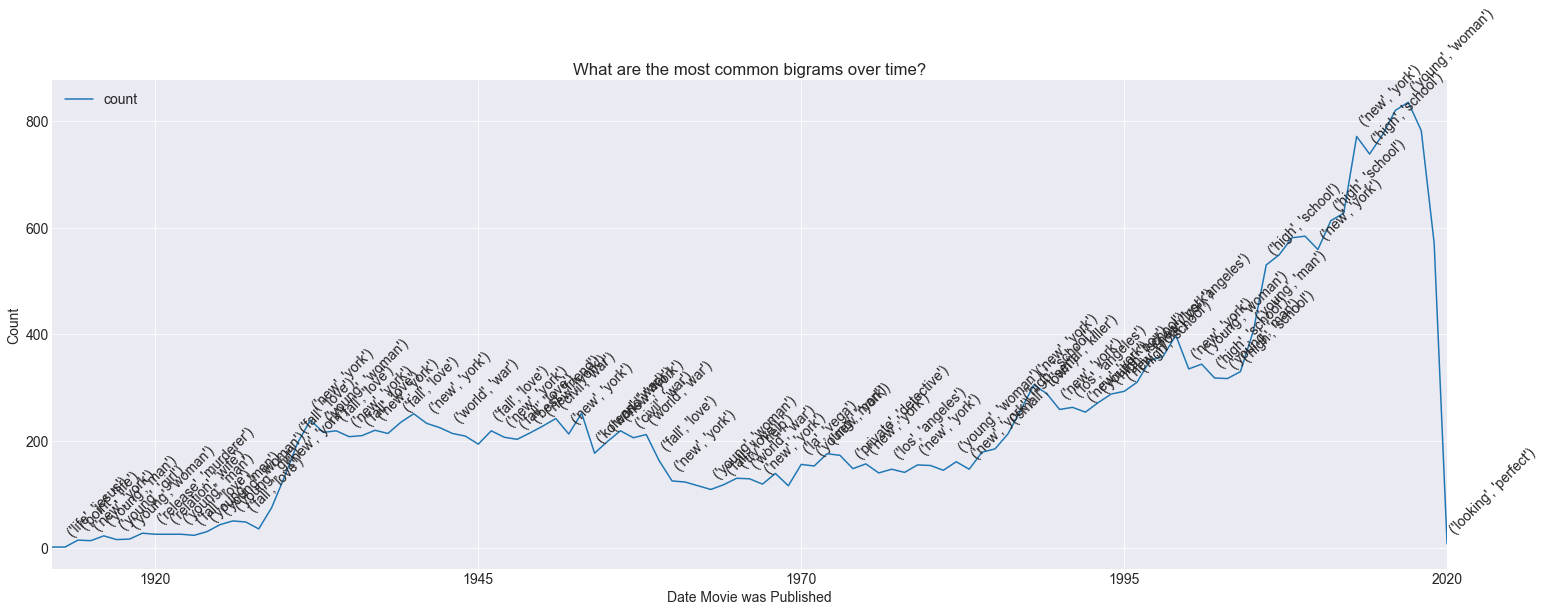

In [100]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over time?")
plt.ylabel("Count")
plt.xlabel("Date Movie was Published")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"][i] != most_common_bigrams["most_frequent_bigram"][i-1]:
        ax.text(f"{most_common_bigrams.index[i]}", most_common_bigrams["count"][i] + 20,  f"{most_common_bigrams.most_frequent_bigram[i]}", rotation = 45)

### Common bigrams in high voted movies vs low?

In [105]:
most_common_bigrams = df.groupby("avg_vote").description.agg([most_frequent_bigram, "count"])

In [108]:
most_common_bigrams

,most_frequent_bigram,count
avg_vote,,
1.1,"(sale, turn)",3
1.2,"(u, destroyer)",7
1.3,"(holy, hell)",8
1.4,"(remains, crucial)",7
1.5,"(consumed, dna)",11
...,...,...
8.9,"(attempt, prevent)",5
9.0,"(new, york)",4
9.2,"(peter, leaf)",2


In [124]:
most_common_bigrams.index[0]

1.1

In [119]:
most_common_bigrams["most_frequent_bigram"].iloc[1]

('u', 'destroyer')

In [125]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over time?")
plt.ylabel("Count")
plt.xlabel("Date Movie was Published")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"].iloc[i] != most_common_bigrams["most_frequent_bigram"].iloc[i-1]:
        ax.text(f"{most_common_bigrams.index[i]}", most_common_bigrams["count"].iloc[i] + 20,  f"{most_common_bigrams.most_frequent_bigram.iloc[i]}", rotation = 45)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1167e4710> (for post_execute):


ConversionError: Failed to convert value(s) to axis units: '1.2'

ConversionError: Failed to convert value(s) to axis units: '1.2'

<Figure size 1800x648 with 1 Axes>

### Common words in high grossing movies vs low?